In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
base_path = Path("/home/antoni/Desktop/ecuadorian store")

In [2]:
holidays_events = pd.read_csv(base_path / 'holidays_events.csv')
oil = pd.read_csv(base_path / 'oil.csv')
items = pd.read_csv(base_path / 'items.csv')
transactions = pd.read_csv(base_path / 'transactions.csv')
stores = pd.read_csv(base_path / 'stores.csv')
sample_submission = pd.read_csv(base_path / 'sample_submission.csv')
train = pd.read_csv(base_path / "train.csv", skiprows=lambda i: i>0 and random.random() > 0.05, low_memory=False)

#### Functions

In [3]:
def percentage_missing(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

def plot_categorical_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(f'Number of occurrences of each category in {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

#### Quick look at holidays_events.

In [4]:
holidays_events.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [5]:
holidays_events.shape

(350, 6)

In [6]:
holidays_events.describe()

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [7]:
holidays_types = holidays_events['type'].unique()
holidays_locality = holidays_events['locale'].unique()

print(holidays_types)
print(holidays_locality)

['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
['Local' 'Regional' 'National']


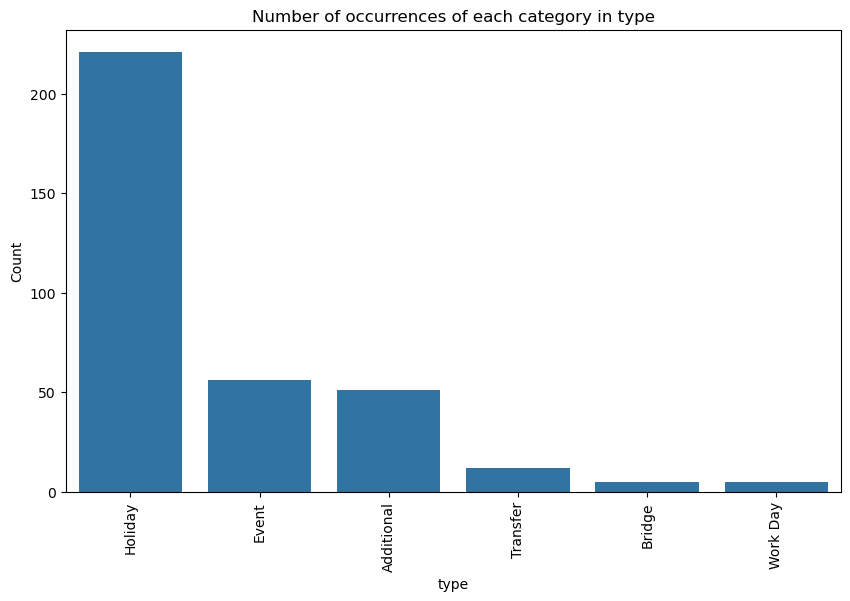

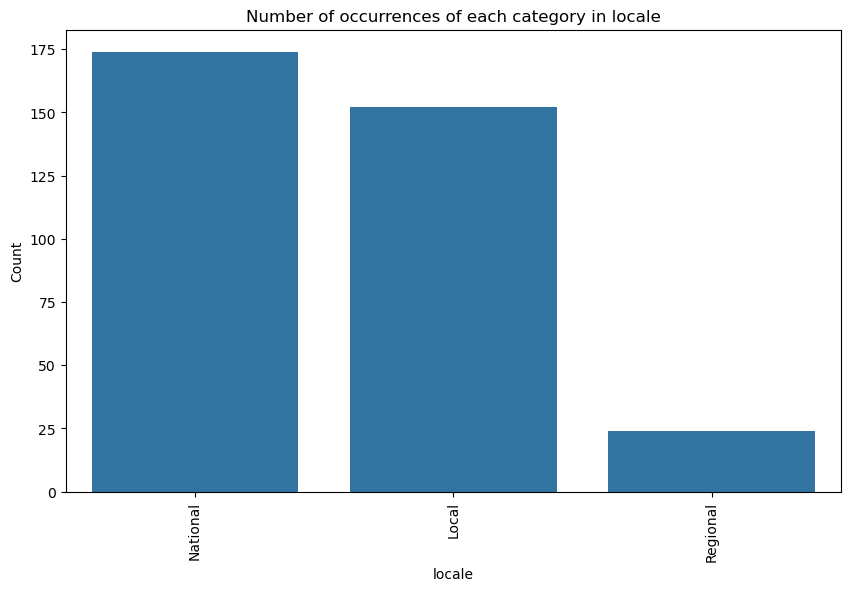

In [8]:
plot_categorical_distribution(holidays_events, 'type')
plot_categorical_distribution(holidays_events, 'locale')

In [9]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [10]:
percentage_missing(holidays_events)

,Total,Percent
date,0,0.0
type,0,0.0
locale,0,0.0
locale_name,0,0.0
description,0,0.0
transferred,0,0.0


In [11]:
holidays_events['date'].min(), holidays_events['date'].max()

('2012-03-02', '2017-12-26')

In [12]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

holidays_events.groupby(holidays_events['date'].dt.year).size()

date
2012    41
2013    51
2014    67
2015    52
2016    86
2017    53
dtype: int64

#### Quick look at oil.

In [13]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [14]:
oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [15]:
percentage_missing(oil)

,Total,Percent
dcoilwtico,43,3.530378
date,0,0.000000


Dates for which oil price information is missing.

In [16]:
oil['date'] = pd.to_datetime(oil['date'])

lacking_oil = pd.date_range(oil.date.min(), oil.date.max()).difference(oil.date)
print(lacking_oil)

DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13', '2017-08-19', '2017-08-20',
               '2017-08-26', '2017-08-27'],
              dtype='datetime64[ns]', length=486, freq=None)


In [17]:
lacking_oil_df = pd.DataFrame(lacking_oil, columns=['date'])



We will check if lack of data for oil price might be connected to a day being a holiday.

In [18]:
lacking_oil_with_holidays = lacking_oil_df.merge(holidays_events, on='date', how='left')

In [19]:
lacking_oil_with_holidays['type'] = lacking_oil_with_holidays['type'].fillna('normal')

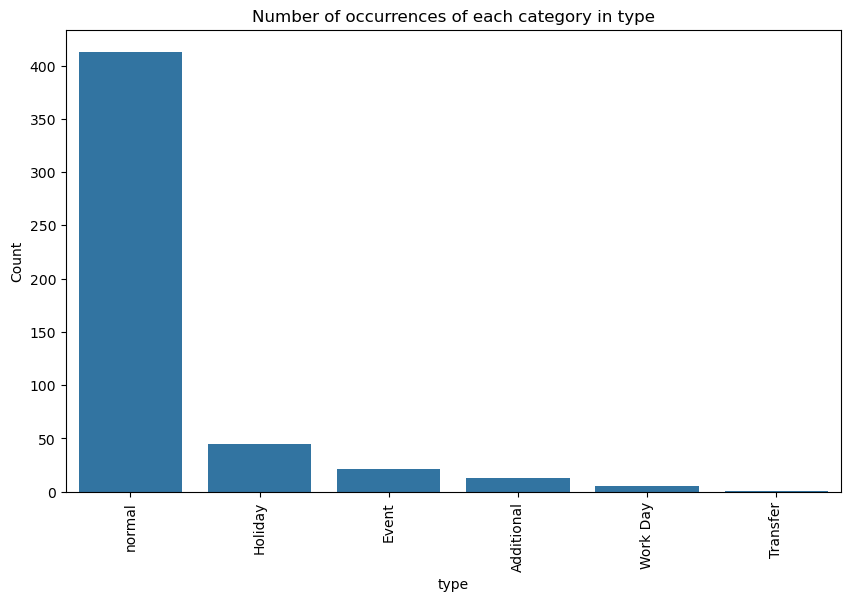

In [20]:
plot_categorical_distribution(lacking_oil_with_holidays, 'type')

Lack of data for oil price does not seem to be dependent on a day being a holiday.

Text(0.5, 1.0, 'Oil price in time')

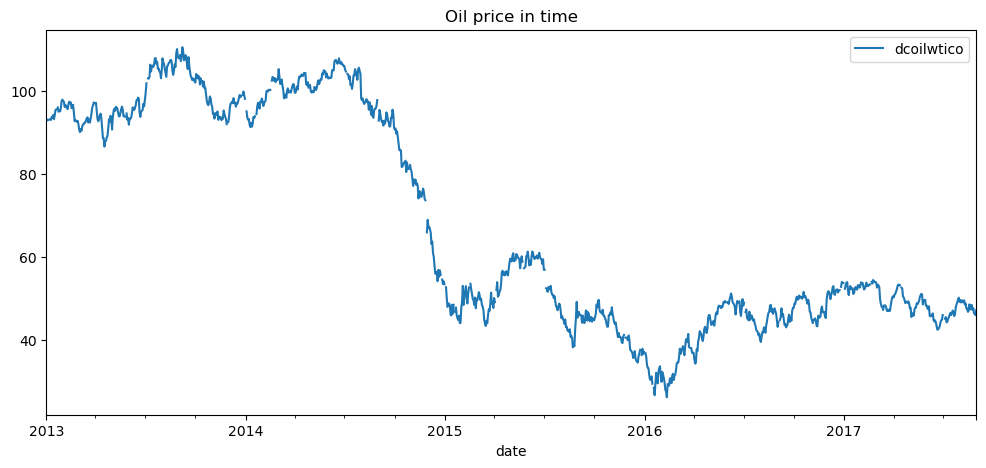

In [21]:
oil.plot(x="date", y="dcoilwtico", figsize=(12,5))
plt.title("Oil price in time")

#### Quick look at items data.

In [22]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [23]:
items.shape

(4100, 4)

In [24]:
percentage_missing(items)

,Total,Percent
item_nbr,0,0.0
family,0,0.0
class,0,0.0
perishable,0,0.0


In [25]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


Number of families of products.

In [26]:
items["family"].nunique()

33

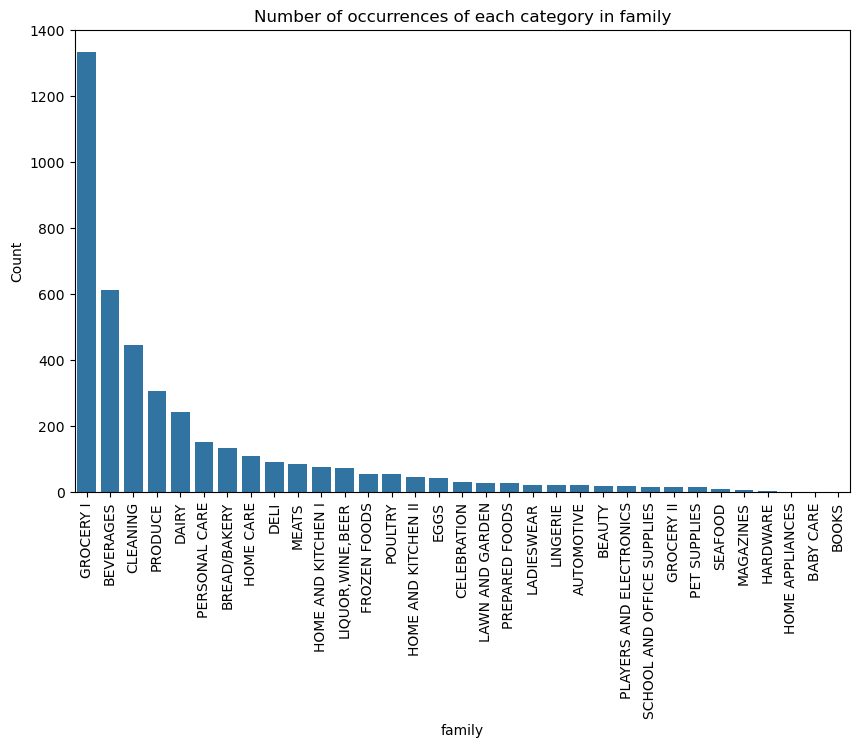

In [27]:
plot_categorical_distribution(items, 'family')

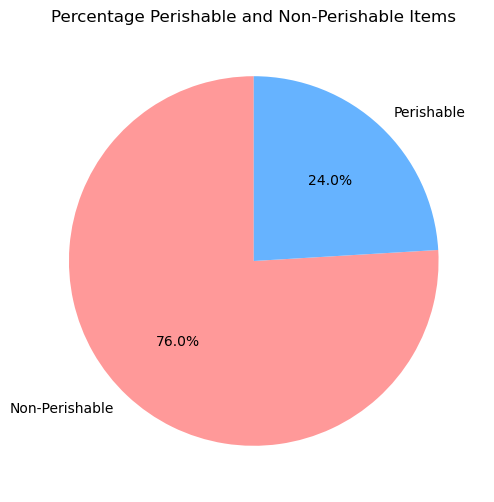

In [28]:
perishable_counts = items['perishable'].value_counts()
labels = ['Non-Perishable', 'Perishable']
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 6))
plt.pie(perishable_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage Perishable and Non-Perishable Items')
plt.show()

In [29]:
train['date'] = pd.to_datetime(train['date'])


#### Quick look at stores data

In [30]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [31]:
percentage_missing(stores)

,Total,Percent
store_nbr,0,0.0
city,0,0.0
state,0,0.0
type,0,0.0
cluster,0,0.0


In [32]:
stores["city"].nunique(), stores["state"].nunique(), stores["type"].unique(), stores["cluster"].nunique()


(22, 16, array(['D', 'B', 'C', 'E', 'A'], dtype=object), 17)

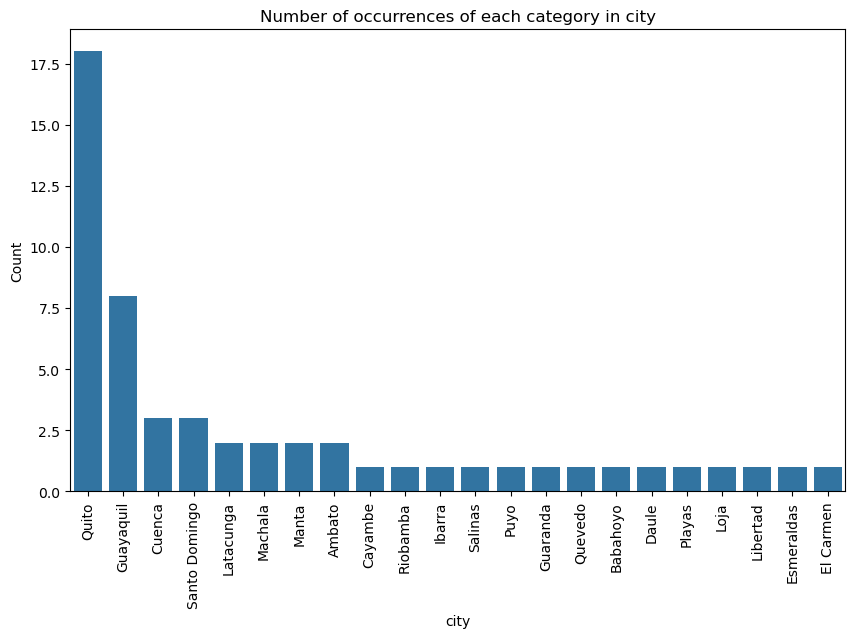

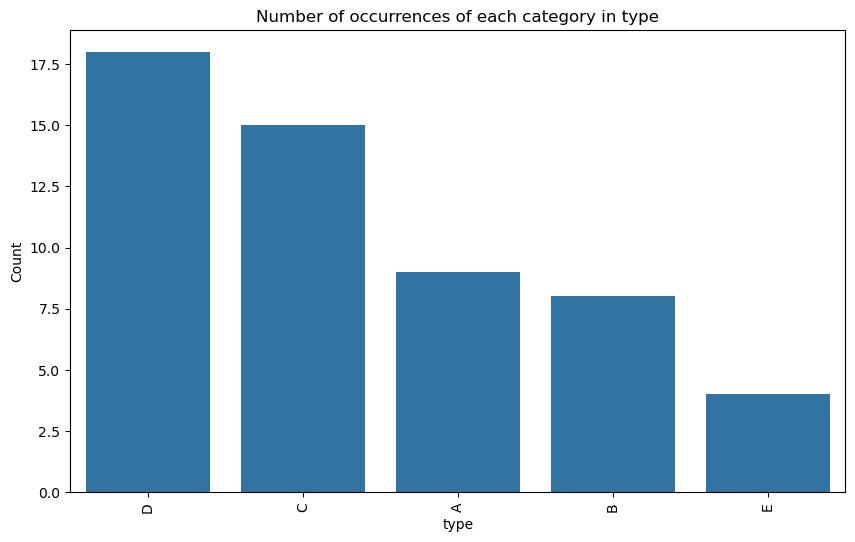

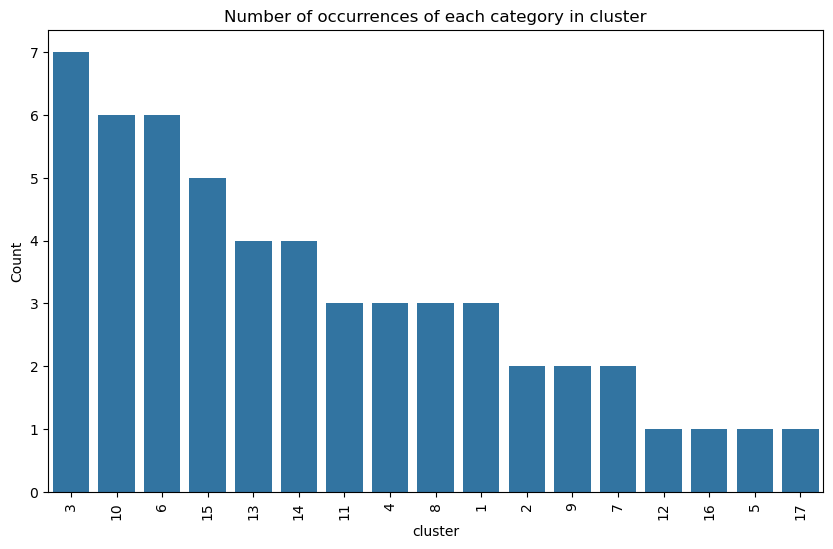

In [33]:
plot_categorical_distribution(stores, 'city')
plot_categorical_distribution(stores, 'type')
plot_categorical_distribution(stores, 'cluster')

#### Quick look at transactions data.

In [34]:
transactions['date'] = pd.to_datetime(transactions['date'])

In [35]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [36]:
transactions["date"].min(), transactions["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [37]:
transactions["store_nbr"].nunique()

54

In [38]:
transactions["transactions"].describe()

count    83488.000000
mean      1694.602158
std        963.286644
min          5.000000
25%       1046.000000
50%       1393.000000
75%       2079.000000
max       8359.000000
Name: transactions, dtype: float64

<AxesSubplot:title={'center':'Number of daily transactions (all stores)'}, xlabel='date'>

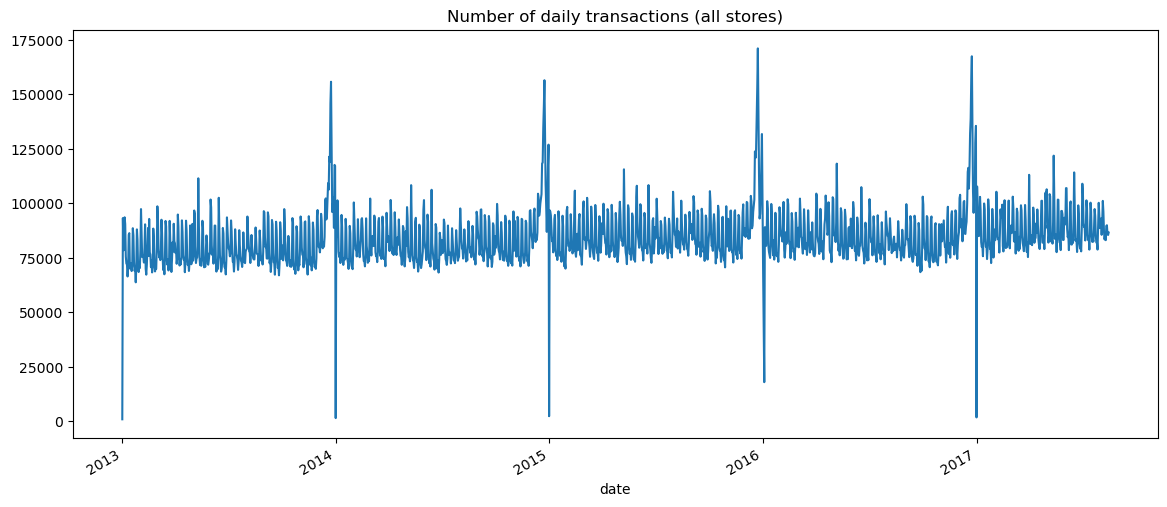

In [39]:
transactions.groupby("date")["transactions"].sum().plot(figsize=(14,6), title="Number of daily transactions (all stores)")


In [40]:
transactions["year"] = transactions["date"].dt.year
transactions["month"] = transactions["date"].dt.month
transactions["dayofweek"] = transactions["date"].dt.dayofweek

<AxesSubplot:title={'center':'Average Transactions by Day of Week'}, xlabel='dayofweek'>

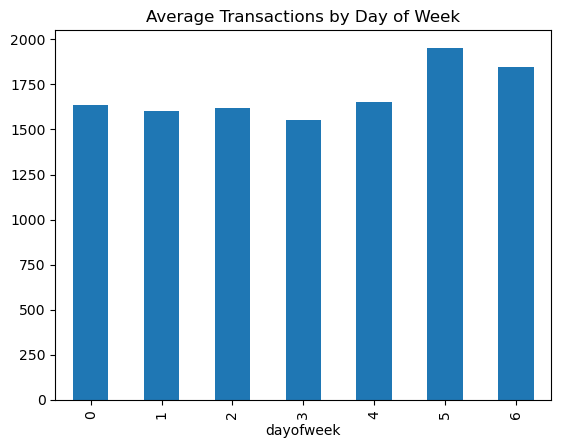

In [41]:
transactions.groupby("dayofweek")["transactions"].mean().plot(kind="bar", title="Average Transactions by Day of Week")

<AxesSubplot:title={'center':'Average Transactions by Month'}, xlabel='month'>

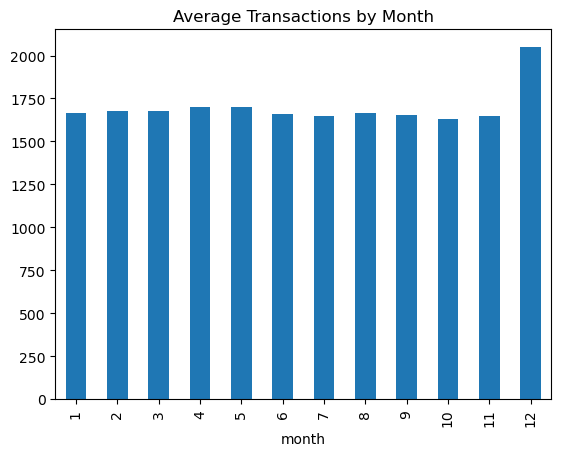

In [42]:
transactions.groupby("month")["transactions"].mean().plot(kind="bar", title="Average Transactions by Month")


<AxesSubplot:xlabel='month', ylabel='dayofweek'>

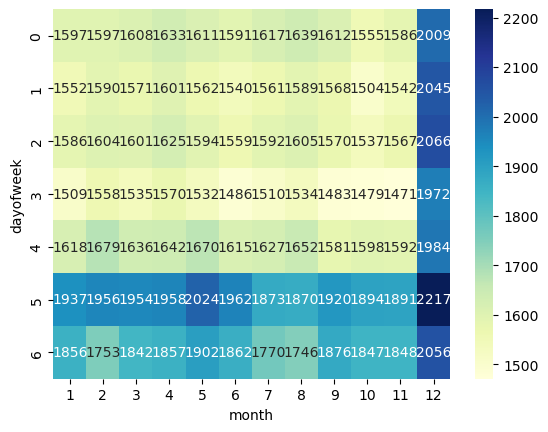

In [43]:
pivot = transactions.pivot_table(index="dayofweek", columns="month", values="transactions", aggfunc="mean")
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")

#### Quick look at train data.

In [44]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,9,2013-01-01,25,114790,3.0,NaN
1,12,2013-01-01,25,115611,1.0,NaN
2,69,2013-01-01,25,220435,4.0,NaN
3,91,2013-01-01,25,265266,1.0,NaN
4,123,2013-01-01,25,315320,1.0,NaN


In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5890145 entries, 0 to 5890144
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   unit_sales   float64       
 5   onpromotion  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 269.6+ MB


In [46]:
percentage_missing(train)

,Total,Percent
onpromotion,1083621,18.397187
id,0,0.000000
date,0,0.000000
store_nbr,0,0.000000
item_nbr,0,0.000000
unit_sales,0,0.000000


In [47]:
train['date'].min(), train['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-06-03 00:00:00'))

In [48]:
train['unit_sales'].min(), train['unit_sales'].max()

(-1943.0, 10700.0)

In [49]:
train['onpromotion'].unique()

array([nan, False, True], dtype=object)

<AxesSubplot:title={'center':'Daily sales over time'}, xlabel='date'>

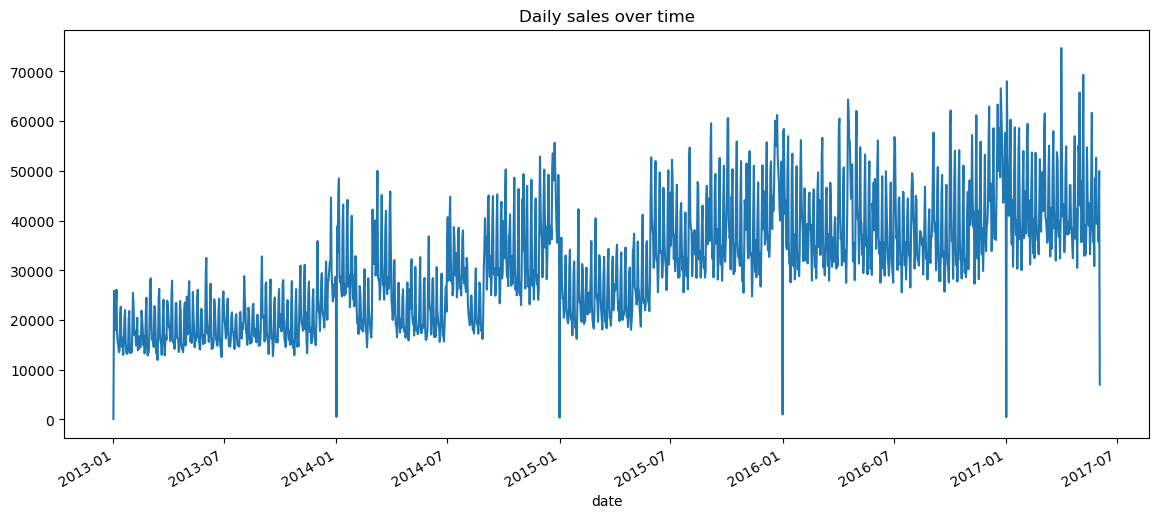

In [50]:
daily_sales = train.groupby("date")["unit_sales"].sum()
daily_sales.plot(figsize=(14,6), title="Daily sales over time")


Interesting thing is that at the begining of a year the sales falls down drasticaly.

<AxesSubplot:title={'center':'Sales by Store'}, xlabel='store_nbr'>

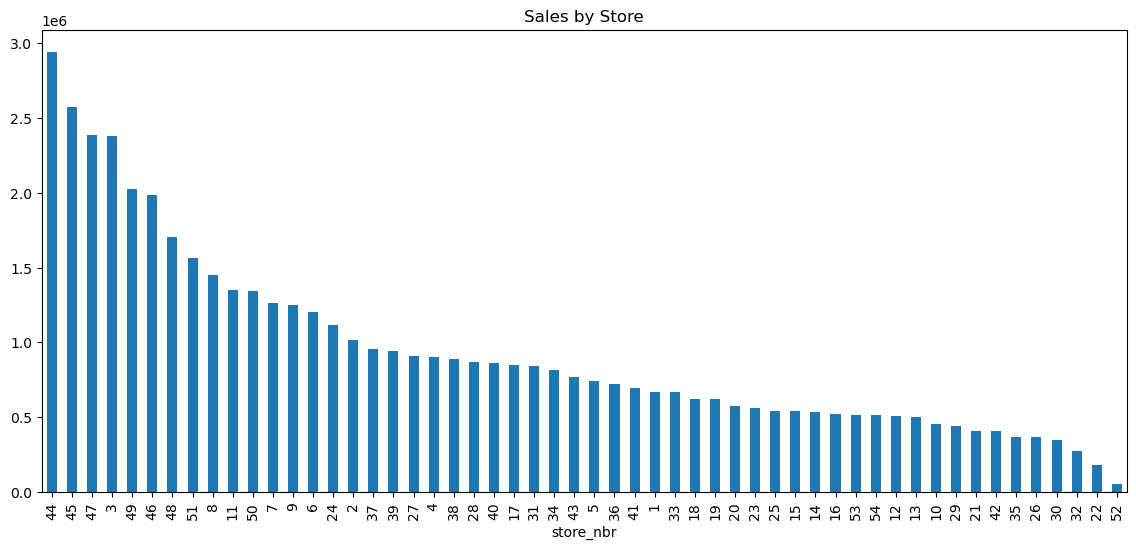

In [51]:
sales_by_store = train.groupby("store_nbr")["unit_sales"].sum().sort_values(ascending=False)
sales_by_store.plot(kind="bar", figsize=(14,6), title="Sales by Store")


<AxesSubplot:title={'center':'Average Sales: Promotion vs No Promotion'}, xlabel='onpromotion'>

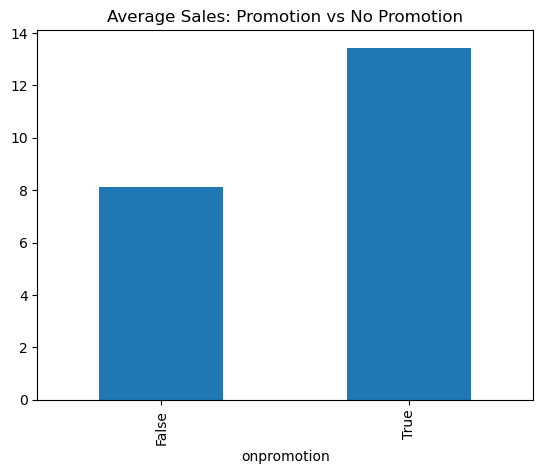

In [52]:
promo_sales = train.groupby("onpromotion")["unit_sales"].mean()
promo_sales.plot(kind="bar", title="Average Sales: Promotion vs No Promotion")


In [53]:
train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month
train["dayofweek"] = train["date"].dt.dayofweek


<AxesSubplot:title={'center':'Average Sales by Day of the Week'}, xlabel='dayofweek'>

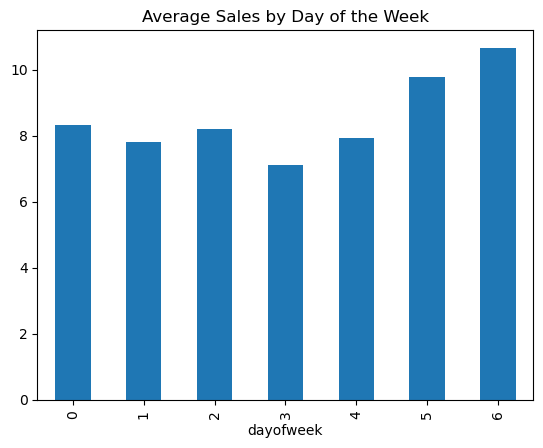

In [54]:
train.groupby("dayofweek")["unit_sales"].mean().plot(kind="bar", title="Average Sales by Day of the Week")

<AxesSubplot:title={'center':'Average Sales by Month'}, xlabel='month'>

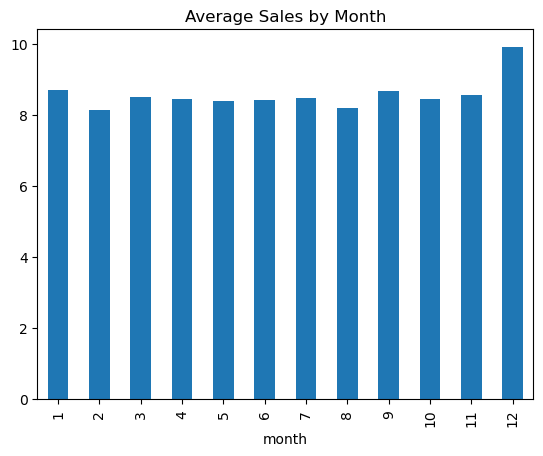

In [55]:
train.groupby("month")["unit_sales"].mean().plot(kind="bar", title="Average Sales by Month")



#### Relations between data.

In [56]:
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [57]:
transactions.head()

,date,store_nbr,transactions,year,month,dayofweek
0,2013-01-01,25,770,2013,1,1
1,2013-01-02,1,2111,2013,1,2
2,2013-01-02,2,2358,2013,1,2
3,2013-01-02,3,3487,2013,1,2
4,2013-01-02,4,1922,2013,1,2


In [58]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [59]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [60]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [61]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,dayofweek
0,9,2013-01-01,25,114790,3.0,NaN,2013,1,1
1,12,2013-01-01,25,115611,1.0,NaN,2013,1,1
2,69,2013-01-01,25,220435,4.0,NaN,2013,1,1
3,91,2013-01-01,25,265266,1.0,NaN,2013,1,1
4,123,2013-01-01,25,315320,1.0,NaN,2013,1,1


In [62]:
train_items = train.merge(items, on="item_nbr", how="left")

Let's see which categories are dominant in sales.

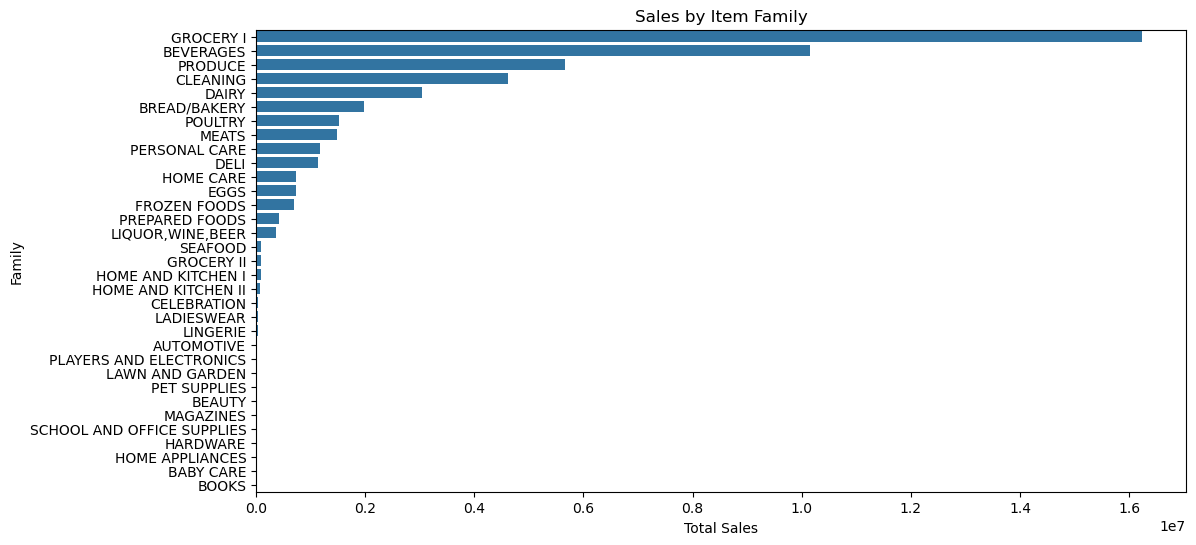

In [63]:
sales_by_family = train_items.groupby("family")["unit_sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=sales_by_family.values, y=sales_by_family.index)
plt.title("Sales by Item Family")
plt.xlabel("Total Sales")
plt.ylabel("Family")
plt.show()

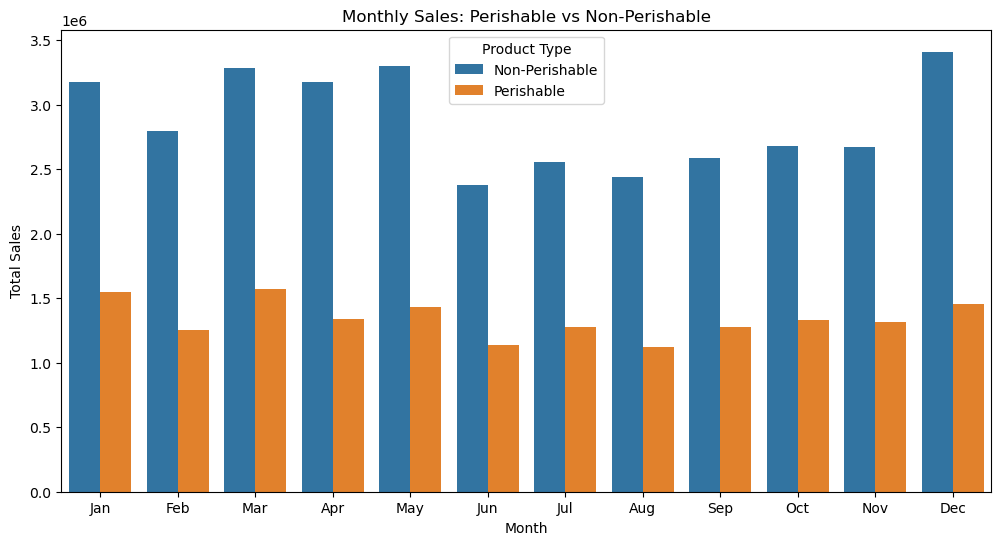

In [64]:
train_items["perishable_flag"] = train_items["perishable"].apply(lambda x: "Perishable" if x == 1 else "Non-Perishable")

monthly_sales = (
    train_items
    .groupby(["month", "perishable_flag"], as_index=False)["unit_sales"]
    .sum()
)
plt.figure(figsize=(12,6))
sns.barplot(
    data=monthly_sales,
    x="month", 
    y="unit_sales", 
    hue="perishable_flag"
)
plt.title("Monthly Sales: Perishable vs Non-Perishable")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.xticks(range(0,12), 
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.legend(title="Product Type")
plt.show()

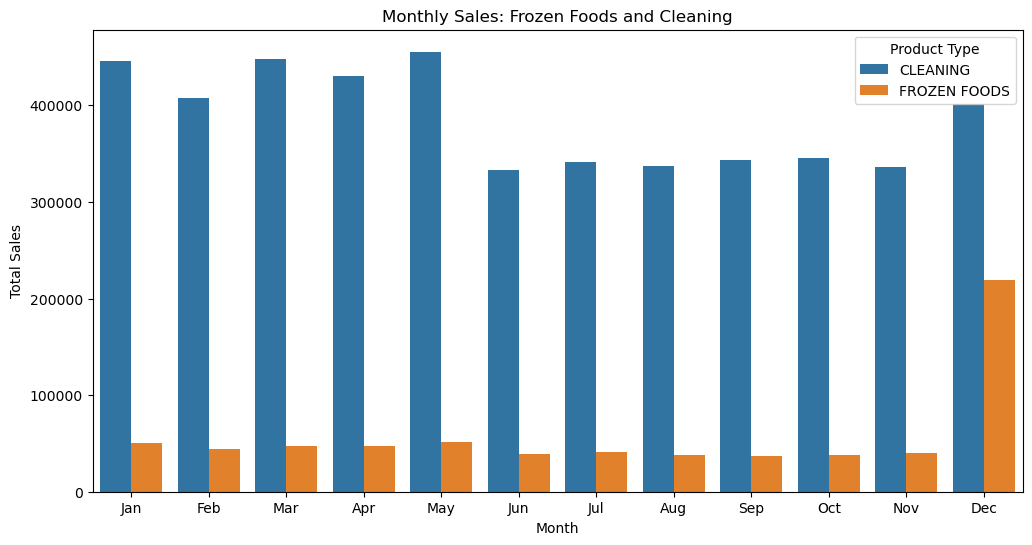

In [65]:
monthly_sales = (
    train_items[train_items["family"].isin(["FROZEN FOODS", "CLEANING"])]
    .groupby(["month", "family"], as_index=False)["unit_sales"]
    .sum()
)
plt.figure(figsize=(12,6))
sns.barplot(
    data=monthly_sales,
    x="month", 
    y="unit_sales", 
    hue="family"
)
plt.title("Monthly Sales: Frozen Foods and Cleaning")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.xticks(range(0,12), 
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.legend(title="Product Type")
plt.show()

We can see that frozen food sold in December outruns the numbers in other months of the year. Also cleaning products are sold more often in cold months.

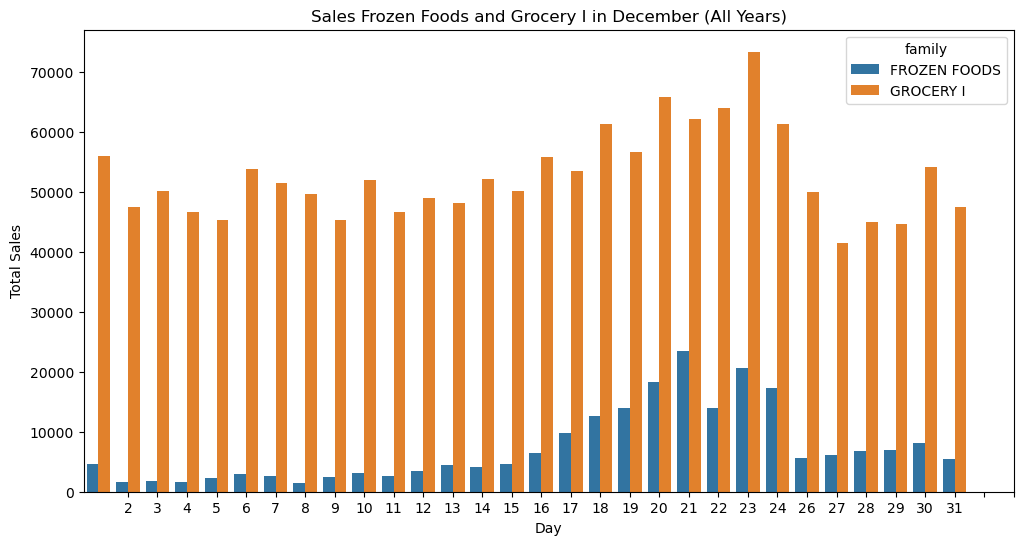

In [66]:
frozen = train_items[
    (train_items["family"].isin(["FROZEN FOODS", "GROCERY I"])) & 
    (train_items["date"].dt.month == 12)
].copy()

# Wyciągamy dzień miesiąca
frozen["day"] = frozen["date"].dt.day

# Sumujemy sprzedaż wg dnia (1–31), niezależnie od roku
frozen_daily = (
    frozen.groupby(["day", "family"], as_index=False)["unit_sales"]
    .sum()
)

# Wykres
plt.figure(figsize=(12,6))
sns.barplot(
    data=frozen_daily,
    x="day", 
    y="unit_sales",
    hue="family",
)
plt.title("Sales Frozen Foods and Grocery I in December (All Years)")
plt.xlabel("Day")
plt.ylabel("Total Sales")
plt.xticks(range(1,32))
plt.show()

As an example, we can observe o frozen foods and grocieries that sales are increased before Christmas and New Year's Eve.

In [67]:
daily_sales = train.groupby("date")["unit_sales"].sum().reset_index()
df = daily_sales.merge(oil, on="date", how="left").rename(columns={"dcoilwtico": "oil_price"})

In [68]:
df['oil_price'].interpolate(method='linear', inplace=True)
df["sales_mean"] = df["unit_sales"].rolling(window=7, min_periods=1).mean()
df["oil_mean"] = df["oil_price"].rolling(window=7, min_periods=1).mean()
df.reset_index(drop=True, inplace=True)


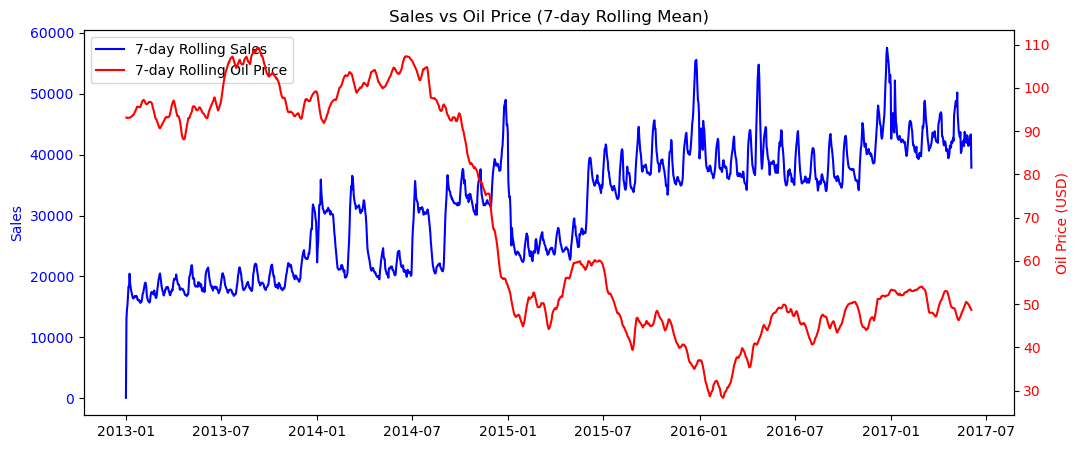

In [69]:
ig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(df['date'].values, df['sales_mean'].values, color='blue', label='7-day Rolling Sales')
ax1.set_ylabel('Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df['date'].values, df['oil_mean'].values, color='red', label='7-day Rolling Oil Price')
ax2.set_ylabel('Oil Price (USD)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Sales vs Oil Price (7-day Rolling Mean)')

# Combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

We can see that when the oil price drops, sales rises up.

In [70]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,dayofweek
0,9,2013-01-01,25,114790,3.0,NaN,2013,1,1
1,12,2013-01-01,25,115611,1.0,NaN,2013,1,1
2,69,2013-01-01,25,220435,4.0,NaN,2013,1,1
3,91,2013-01-01,25,265266,1.0,NaN,2013,1,1
4,123,2013-01-01,25,315320,1.0,NaN,2013,1,1


In [71]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
train['date'] = pd.to_datetime(train['date'])

valid_holidays = holidays_events[holidays_events['transferred'] == False][['date', 'type']]

train_holidays = train.merge(valid_holidays, on="date", how="left")
train_holidays.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,dayofweek,type
0,9,2013-01-01,25,114790,3.0,NaN,2013,1,1,Holiday
1,12,2013-01-01,25,115611,1.0,NaN,2013,1,1,Holiday
2,69,2013-01-01,25,220435,4.0,NaN,2013,1,1,Holiday
3,91,2013-01-01,25,265266,1.0,NaN,2013,1,1,Holiday
4,123,2013-01-01,25,315320,1.0,NaN,2013,1,1,Holiday


In [72]:
sales_by_holiday = (
    train_holidays.groupby("type")["unit_sales"]
    .mean()
    .sort_values(ascending=False)
)
print(sales_by_holiday)

type
Additional    10.746012
Work Day      10.148664
Bridge         9.807403
Transfer       8.998564
Event          8.916415
Holiday        8.702474
Name: unit_sales, dtype: float64


In [78]:
train_holidays['is_holiday'] = train_holidays['type'].notna().astype(int)

In [79]:
train_holidays.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,dayofweek,type,is_holiday
0,9,2013-01-01,25,114790,3.0,NaN,2013,1,1,Holiday,1
1,12,2013-01-01,25,115611,1.0,NaN,2013,1,1,Holiday,1
2,69,2013-01-01,25,220435,4.0,NaN,2013,1,1,Holiday,1
3,91,2013-01-01,25,265266,1.0,NaN,2013,1,1,Holiday,1
4,123,2013-01-01,25,315320,1.0,NaN,2013,1,1,Holiday,1


In [81]:
valid_holidays["day_before"] = valid_holidays["date"] - pd.Timedelta(days=1)

In [83]:
train_before_holiday = train.merge(
    valid_holidays[["day_before","type"]],
    left_on="date", right_on="day_before", how="left"
)

In [85]:
train_before_holiday["before_holiday"] = train_before_holiday["type"].notna().astype(int)

In [87]:
sales_before = train_before_holiday.groupby("before_holiday")["unit_sales"].mean()
print(sales_before)

before_holiday
0    8.501579
1    9.015059
Name: unit_sales, dtype: float64


In [90]:
sales_by_holiday = (
    train_holidays.groupby("type")["unit_sales"]
    .mean()
    .sort_values(ascending=False)
)
print(sales_by_holiday)

type
Additional    10.746012
Work Day      10.148664
Bridge         9.807403
Transfer       8.998564
Event          8.916415
Holiday        8.626628
Name: unit_sales, dtype: float64


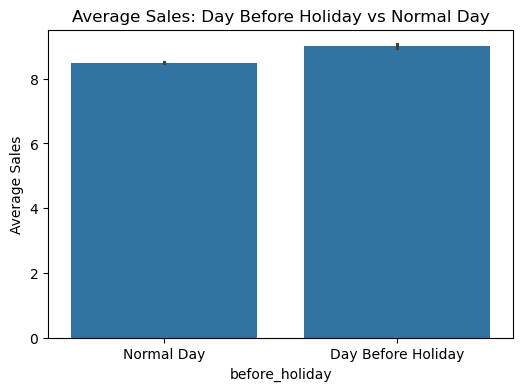

In [91]:
plt.figure(figsize=(6,4))
sns.barplot(
    x="before_holiday", 
    y="unit_sales", 
    data=train_before_holiday, 
    estimator="mean"
)
plt.xticks([0,1], ["Normal Day", "Day Before Holiday"])
plt.ylabel("Average Sales")
plt.title("Average Sales: Day Before Holiday vs Normal Day")
plt.show()